In [1]:
from AFEP_parse import *

from IPython.display import display, Markdown

import warnings #Suppress future warnings from pandas.
warnings.simplefilter(action='ignore', category=FutureWarning)

# How to Use this Notebook:

## This notebook is specially written for the SAFEP tutorial. 
For more up-to-date and general versions see the SAFEP github.

## This and other SAFEP notebooks make use of pyMBAR and Alchemlyb. 
For more information see Shirts and Chodera (2008), "Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

## User Parameters:
**IMPORTANT: Make sure the temperature matches the temperature used to run the simulations.** <br>
The decorrelate flag should be set to True for general use. <br>
The detectEQ (automatic equilibrium detection) flag is optional. If you have very poor convergence but believe your system is well-sampled, you may wish to try it.

In [2]:
temperature = 300
radius = 3 #Radius of the spherical restraint used for the DBC TI calculation

decorrelate = True #Flag for automatic decorrelation
detectEQ = False #Flag for automatic equilibrium detection
RT = 0.00198720650096 * temperature # RT in kcal/mol

root = '..' #Root path to fepout files

***
# Process the Bound Data

In [3]:
path=f'{root}/AFEP-Bound-Decoupling/output/' #Path to fepout files
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file
#Caution: if you have multiple fepout files, name them alphanumerically

In [4]:
fepoutFiles = glob(path+filename) #Resolve any naming regular expressions
u_nk, _ = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = doEstimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = doConvergence(u_nk) #Used later in the convergence plot

dG_site = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error_site = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)
changeAndError = f'\u0394G<sub>site</sub> = {dG_site}\u00B1{error_site} kcal/mol'
Markdown('<font size=7>{}</font><br/>'.format(changeAndError))

Decorrelating samples. Flag='True'


<font size=7>ΔG<sub>site</sub> = 14.9±0.1 kcal/mol</font><br/>

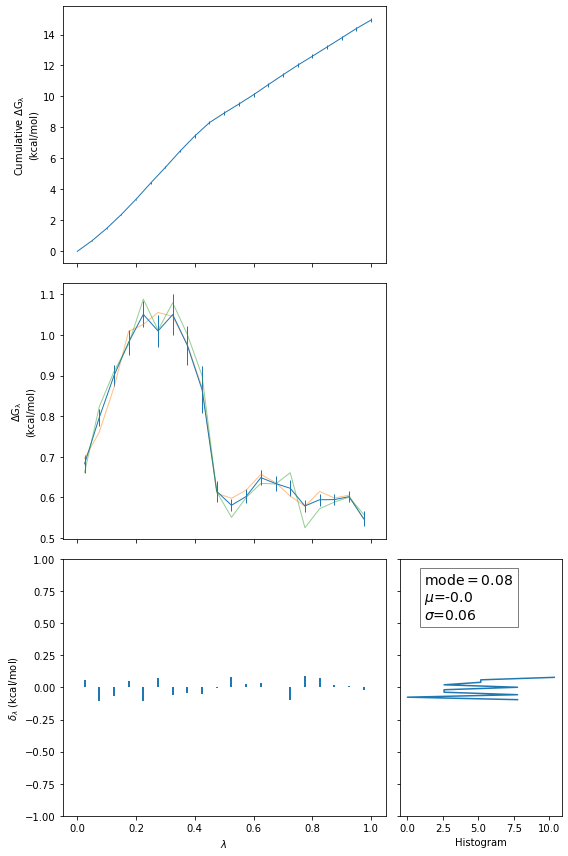

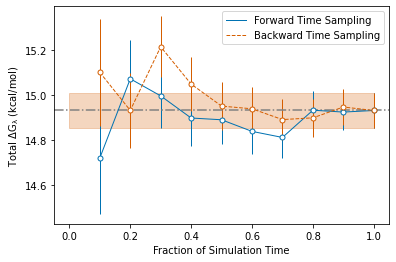

In [5]:
#Make some general plots
width = 8
height = 4
fig, axes = plotGeneral(cumulative, perWindow, RT, width=width, height=height, PDFtype='Histogram')
plt.savefig(f'{path}_bound_generalFigures.pdf')
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = convergencePlot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)

fig.set_figwidth(width*3/4)
fig.set_figheight(height)

plt.savefig(f'{path}_bound_convergence.pdf')
plt.show()

***
# Process the Unbound Data

In [6]:
path=f'{root}/AFEP-Hydration/'
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file

fepoutFiles = glob(path+filename)


In [7]:
fepoutFiles = glob(path+filename) #Resolve any naming regular expressions
u_nk, _ = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = doEstimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = doConvergence(u_nk) #Used later in the convergence plot

dG_bulk = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error_bulk = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)
changeAndError = f'\u0394G<sub>bulk</sub> = {dG_site}\u00B1{error_site} kcal/mol'
Markdown('<font size=7>{}</font><br/>'.format(changeAndError))

Decorrelating samples. Flag='True'


<font size=7>ΔG<sub>bulk</sub> = 14.9±0.1 kcal/mol</font><br/>

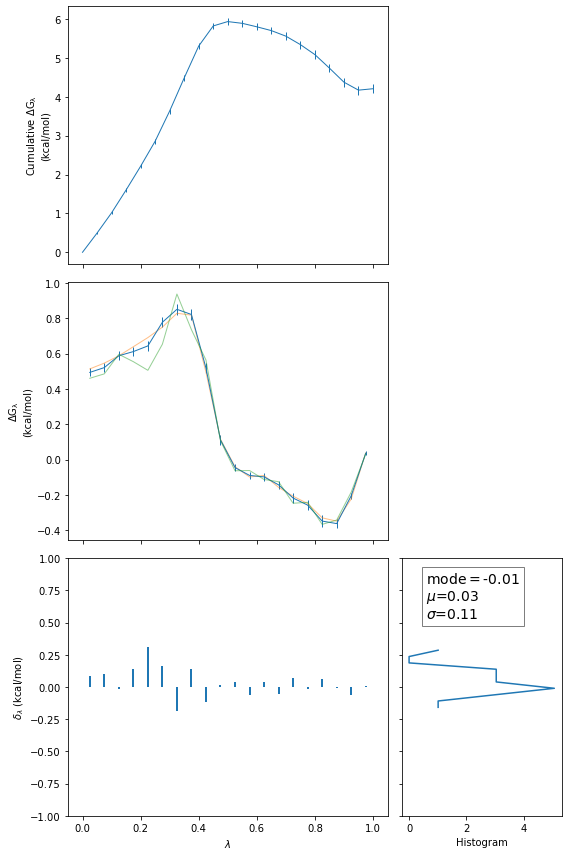

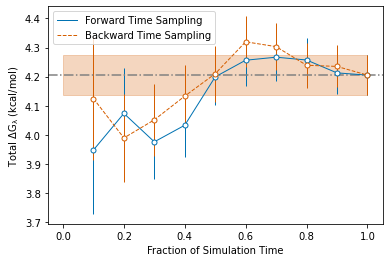

In [8]:
width = 8
height = 4
fig, axes = plotGeneral(cumulative, perWindow, RT, width=width, height=height, PDFtype='Histogram')
plt.savefig(f'{path}_bound_generalFigures.pdf')
#plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = convergencePlot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)
convAx.set(xlabel='Fraction of Simulation Time', ylabel=r'Total $\rm\Delta G_{\lambda}$ (kcal/mol)')
fig.set_figwidth(width*3/4)
fig.set_figheight(height)
convAx.legend()
plt.savefig(f'{path}_bound_convergence.pdf')
plt.show()

***
# Process the DBC TI calculation

In [9]:
def plotTI(cumulative, perWindow, width=8, height=4, PDFtype='KDE', hystLim=(-1,1), color='#0072B2'):
    fig, (cumAx,eachAx) = plt.subplots(2,1, sharex='col')

    # Cumulative change in kcal/mol
    cumAx.errorbar(cumulative.index, cumulative.dG, yerr=cumulative.error,marker=None, linewidth=1, color=color, label='Cumulative Change')
    finalEstimate = cumulative.dG[1]
    cumAx.axhline(finalEstimate, linestyle='-', color='gray', label=f'Final Value:\n{np.round(finalEstimate,1)}kcal/mol')
    cumAx.legend()                  
    cumAx.set(ylabel=r'Cumulative $\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

    # Per-window change in kcal/mol
    eachAx.errorbar(perWindow.index, perWindow.dGdL, marker=None, linewidth=1, yerr=perWindow.error, color=color)
    eachAx.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

    fig.set_figwidth(width)
    fig.set_figheight(height*3)
    fig.tight_layout()
    
    return fig, [cumAx,eachAx] 

In [10]:
def makeHarmonicWall(FC=10, targetFC=0, targetFE=1, upperWalls=1, schedule=None, numSteps=1000, targetEQ=500, name='HW', lowerWalls=None):
    HW = {'name':name, 'targetFC':targetFC, 'targetFE':targetFE, 'FC':FC, 'upperWalls':upperWalls, 'schedule':schedule, 'numSteps':numSteps, 'targetEQ':targetEQ, 'lowerWalls':lowerWalls}
    return HW

def HW_U(HW, coord, L):
    d=0
    if HW['upperWalls'] and coord>HW['upperWalls']:
        d = coord-HW['upperWalls']
    elif HW['lowerWalls'] and coord<HW['lowerWalls']:
        d = coord-HW['lowerWalls']
    
    if d!=0:
        dk = HW['targetFC']-HW['FC']
        la = L**HW['targetFE']
        kL = HW['FC']+la*dk
        U = 0.5*kL*(d**2)
    else:
        U=0
    return U

def HW_dUdL(HW, coord, L):
    d=0
    if HW['upperWalls'] and coord>HW['upperWalls']:
        d = coord-HW['upperWalls']
    elif HW['lowerWalls'] and coord<HW['lowerWalls']:
        d = coord-HW['lowerWalls']
    
    if d!=0:
        dk = HW['targetFC']-HW['FC']
        dla = HW['targetFE']*L**(HW['targetFE']-1)
        kL = HW['FC']+dla*dk
        dU = 0.5*kL*(d**2)
    else:
        dU=0
    return dU

In [25]:
path = f'{root}/RFEP/output/'
dataTI = pd.read_csv(glob(path+'*.colvars.traj')[0], delim_whitespace=True, names=['step','DBC', 'distance', 'E_dist', 'E_DBC'], comment='#', index_col=0)
dataTI = dataTI[dataTI.index>=1000][1:]
dataTI.index = dataTI.index-1000

#For comparison to current method. Not needed in release form.
RFEPdat = pd.read_csv(glob(path+'RFEP.dat')[0], delim_whitespace=True, names=['L', 'dGperL'], comment='#', index_col=0)

nLambdas = 41
Lsched = np.linspace(1,0,nLambdas)

Dist = makeHarmonicWall(FC=200, upperWalls=radius, name='Dist_rest')
DBC = makeHarmonicWall(FC=0, targetFC=200, targetFE=6, upperWalls=1.5, targetEQ=500, numSteps=300000, name='DBC_rest', schedule=Lsched)
Ls = (dataTI.index.values-1)//DBC['numSteps']
Ls[0] = 0
Ls[Ls==41] = 40 #Fix in case there are extra samples for the last window

In [12]:
dataLs = np.round([DBC['schedule'][i] for i in Ls], 3)
dataTI.loc[:,'L'] = dataLs
dataTI = dataTI.iloc[1:]

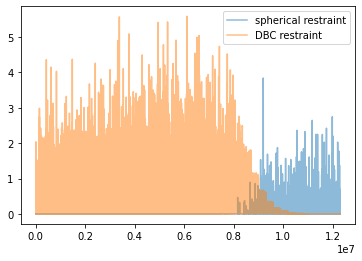

In [13]:
# Probably not relevant for the tutorial

if np.isnan(dataTI.E_dist.iloc[0]):
    dataTI.loc[:,'E_dist'] = [HW_U(Dist, coord, 0) for coord in dataTI.distance]
if np.isnan(dataTI.E_DBC.iloc[0]):
    dataTI.loc[:,'E_DBC'] = [HW_U(DBC, coord, L) for coord, L in zip(dataTI.DBC, dataTI.L)]

plt.plot(dataTI.E_dist, label='spherical restraint', alpha=0.5)
plt.plot(dataTI.E_DBC, label='DBC restraint', alpha=0.5)
plt.legend()
plt.savefig(f'{path}_restraint_overlap.pdf')

In [14]:
dataTI

,DBC,distance,E_dist,E_DBC,L
step,,,,,
100,0.473746,0.151991,0.0,0.000000,1.0
200,0.907909,0.184391,0.0,0.000000,1.0
300,1.349532,0.204476,0.0,0.000000,1.0
400,1.642606,0.262815,0.0,2.033649,1.0
500,1.419225,0.202707,0.0,0.000000,1.0
...,...,...,...,...,...
12299600,5.495376,5.155835,0.0,0.000000,0.0
12299700,5.554957,5.239712,0.0,0.000000,0.0
12299800,5.640530,5.359187,0.0,0.000000,0.0


In [26]:
dUs = {}
for key, group in dataTI.groupby('L'):
    dUs[key] = [HW_dUdL(DBC, coord, key) for coord in group.DBC]


Lsched = np.sort(list(dUs.keys()))
dL = Lsched[1] - Lsched[0]
TIperWindow = pd.DataFrame(index=Lsched)
TIperWindow['dGdL'] = [np.mean(dUs[L])*dL for L in Lsched]
TIperWindow['error'] = [np.std(dUs[L])*dL for L in Lsched]

TIcumulative = pd.DataFrame()
TIcumulative['dG'] = np.cumsum(TIperWindow.dGdL)
TIcumulative['error'] = np.sqrt(np.divide(np.cumsum(TIperWindow.error**2), np.range(1,lenTIperWindow)))


KeyError: 'L'

In [16]:
dG_DBC = np.round(TIcumulative['dG'][1], 1)
error_DBC = np.round(TIcumulative['error'][1], 1)
changeAndError = f'\u0394G<sub>DBC</sub> = {dG_DBC}\u00B1{error_DBC} kcal/mol'
Markdown('<font size=7>{}</font><br/>'.format(changeAndError))

<font size=7>ΔG<sub>DBC</sub> = 3.9±0.1 kcal/mol</font><br/>

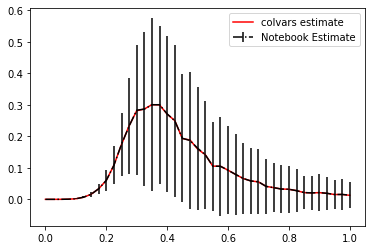

In [17]:
fwdColor='#0072B2'
bwdColor='#D55E00'
plt.plot(RFEPdat, label='colvars estimate', color='red')
plt.errorbar(Lsched, TIperWindow['dGdL'], yerr=TIperWindow['error'], label='Notebook Estimate', linestyle='-.', color='black')
plt.savefig(f'{path}_TI_vs_colvarEst.pdf')
plt.legend()

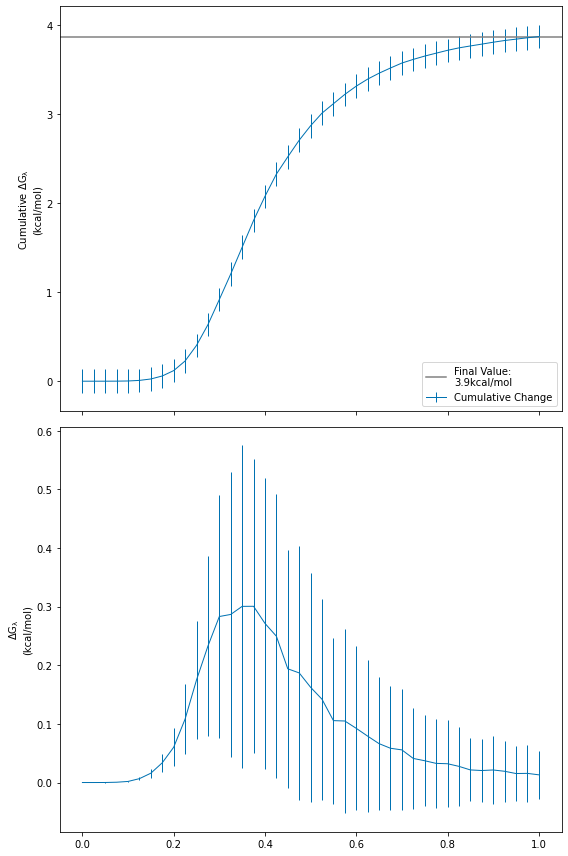

In [18]:
fig, axes = plotTI(TIcumulative, TIperWindow)
plt.savefig(f'{path}_TI_general.pdf')
plt.show()

***
# Calculate the Volumetric Restraint Contribution

In [19]:
molar = 1660 #cubic angstroms per particle in a one molar solution
dG_V = np.round(-RT*np.log(4/3*sp.pi*radius**3/molar), 1)
error_V = 0

In [20]:
dG_V

1.6

***
# Compute the final estimate

In [23]:
dG_binding = dG_bulk + dG_V + dG_DBC - dG_site
error_binding = np.sqrt(np.mean(np.array([error_bulk, error_V, error_site, error_DBC])**2))

In [24]:
print(f'\u0394G = {np.round(dG_binding, 1)}\u00B1{np.round(error_binding, 1)} kcal/mol')

ΔG = -5.2±0.1 kcal/mol
